# Testing Tesseract OCR performance on custom fonts



In [1]:
import numpy as np              # Vector math
import matplotlib.pyplot as plt # Plotting
import os
import pandas as pd
%matplotlib inline

In [2]:
SAMPLEFONT = "gentium-r.ttf"
SAMPLETEXT = "Šámpľë text!\nŠámpľë text!\nŠámpľë text!"

## Set up functions

Here we set up functions to read font data, render text as images, OCR them and perform error metrics.

The following function extracts font name from a TTF or OTF file.

In [3]:
from fontTools.ttLib import TTFont

def get_font_name(fontfile):
    font = TTFont(fontfile)
    for record in font["name"].names:
        if record.nameID == 4:
            return record.toUnicode()
        
# Example
print(get_font_name(SAMPLEFONT))

Gentium Plus


The following two functions render given text using a given font file. `render_text_bw` produces an image of only black and white pixels. `render_text_gray` uses grayscale, so the image looks smoother.

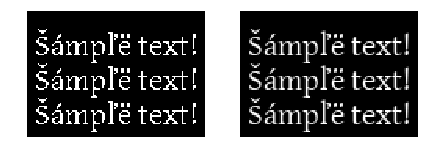

In [4]:
from PIL import ImageFont, ImageDraw, Image

def render_text_bw(texttorender, fontfile, ptsize=20, linespacing=0, as_nparray=True):
    font = ImageFont.truetype(fontfile, ptsize)
    # Create a dummy image, draw text and find out its size 
    pimg = Image.new("L", (1, 1))
    draw = ImageDraw.Draw(pimg)
    x,y = draw.textsize(texttorender, font=font, spacing=linespacing)
    # Create a new image large enough for the text
    pimg = Image.new("L", (x+10,y+15))
    draw = ImageDraw.Draw(pimg)
    draw.text((5,7), texttorender, fill=1, font=font, spacing=linespacing)
    if as_nparray:
        return np.array(pimg,dtype=np.uint8)
    return pimg

def render_text_gray(texttorender, fontfile, ptsize=20, linespacing=0, as_nparray=True):
    font = ImageFont.truetype(fontfile, ptsize)
    pimg = Image.new("RGB", (1, 1))
    draw = ImageDraw.Draw(pimg)
    x,y = draw.textsize(texttorender, font=font, spacing=linespacing)
    pimg = Image.new("RGB", (x+10,y+15))
    draw = ImageDraw.Draw(pimg)
    draw.text((5,7), texttorender, fill=(255,255,255), font=font, spacing=linespacing)
    if as_nparray:
        return np.array(pimg,dtype=np.uint8)[:,:,0]
    return pimg

# Example
fig = plt.figure(figsize=(7, 7))
fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.imshow(render_text_bw(SAMPLETEXT, SAMPLEFONT), cmap='gray')
fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.imshow(render_text_gray(SAMPLETEXT, SAMPLEFONT), cmap='gray')
plt.show()

The following two functions serve for previewing fonts in a directory.

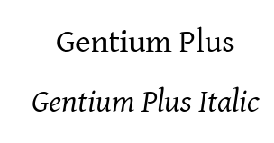

In [133]:
def get_font_names(directory):
    fontdata = []
    i = 0
    files = os.listdir(directory)
    for name in files:
        path = os.path.join(directory, name)
        if not (os.path.isfile(path) and name[-3:].lower() in ("otf","ttf")):
            continue
        data = {"id": i}
        data["path"] = path
        data["name"] = get_font_name(path)
        fontdata.append(data)
        i += 1
    return pd.DataFrame(fontdata).set_index("id")

def preview_fonts(fontdata):
    previews = []
    for row in fontdata.sort_values(by="name").itertuples():
        img = render_text_gray(getattr(row,"name"), getattr(row,"path"), 36)
        previews.append(255-img)

    fig = plt.figure(figsize=(12, len(previews)))
    for i in range(len(previews)):
        fig.add_subplot(len(previews), 1, i+1)
        plt.axis('off')
        plt.imshow(previews[i], cmap='gray')
    plt.show()

# Example
fonts_preview(get_font_names("."))

## Pipeline

The pipeline is as follows:

- Read and format the original text;
- Batch render text in desired fonts and point sizes, save as PNG;
- Batch OCR produced images, save as TXT;
- Evaluate TXT files.

We also need a function to manage the metadata of our files (`make_experiment_setup`). Here we define the functions to perform these steps.

In [24]:
import pytesseract

def breaklines(text, char_limit=60):
    settext = []
    for par in text.split("\n"):
        chunk = []
        chunk_len = 0
        for word in par.split(" "):
            if len(word) + chunk_len > char_limit:
                settext.append(" ".join(chunk))
                chunk = []
                chunk_len = 0
            chunk.append(word)
            chunk_len += len(word)
        splitpar = " ".join(chunk)
        if splitpar:
            settext.append(splitpar)
    return "\n".join(settext)

def make_experiment_setup(fontdata, ptsizelist, outdir):
    imgdir = os.path.join(outdir,"img")
    txtdir = os.path.join(outdir,"txt")
    os.makedirs(imgdir, exist_ok=True)
    os.makedirs(txtdir, exist_ok=True)
    
    setup = pd.DataFrame(columns="fontid ptsize img txt".split())
    
    for font in fontdata.itertuples():
        fontid = getattr(font,"Index")
        for ptsize in ptsizelist:
            img = os.path.join(imgdir,"{:02}.{}.png".format(fontid,ptsize))
            txt = os.path.join(txtdir,"{:02}.{}.txt".format(fontid,ptsize))
            setup = setup.append({"fontid": fontid, "ptsize": ptsize, "img": img, "txt": txt}, ignore_index=True)
            
    return setup
    

def batch_render_text(text, setup, fontdata):
    for row in setup.itertuples():
        fontfile = fontdata.iloc[getattr(row,"fontid")]["path"]
        filename = getattr(row,"img")
        ptsize = getattr(row,"ptsize")
        img = render_text_bw(text, fontfile, ptsize, linespacing=ptsize//2, as_nparray=False)
        img.save(filename)
        print("Wrote", filename)
            
def batch_ocr_images(setup, language="eng"):
    for row in setup.itertuples():
        imgname = getattr(row,"img")
        txtname = getattr(row,"txt")
        img = np.array(Image.open(imgname),dtype=np.uint8)
        txt = pytesseract.image_to_string(img, lang=language)
        txt = txt.replace("\n\n","\n")
        with open(txtname,"w") as out:
            out.write(txt)
        print("Wrote", txtname)

# Example
fontdata = get_font_names(".")
setup = make_experiment_setup(fontdata, [20,30], "test")
setup.to_csv("test/setup.csv")
batch_render_text(SAMPLETEXT, setup, fontdata)
batch_ocr_images(setup, "ces")

Wrote test/img/00.20.png
Wrote test/img/00.30.png
Wrote test/img/01.20.png
Wrote test/img/01.30.png
Wrote test/txt/00.20.txt
Wrote test/txt/00.30.txt
Wrote test/txt/01.20.txt
Wrote test/txt/01.30.txt


We evaluate using the Word Error Rate and the Character Error Rate.

In [94]:
from nltk.metrics import edit_distance

def WER(s1, s2):
    tok1, tok2 = s1.split(), s2.split()
    return edit_distance(tok1, tok2)/max(len(tok1), len(tok2))

def CER(s1, s2):
    tok1, tok2 = list(s1), list(s2)
    return edit_distance(tok1, tok2)/max(len(tok1), len(tok2))

def batch_evaluate(setup, fontdata, orig_text):
    results = pd.DataFrame(columns="Font id,Font,Point size,WER,CER,txt".split(","))
    for row in setup.itertuples():
        fontid = getattr(row,"fontid")
        font = fontdata.iloc[fontid]["name"]
        txtfile = getattr(row,"txt")
        ptsize = getattr(row,"ptsize")
        with open(txtfile, "r") as fin:
            ocr_text = fin.read()
            wer = WER(orig_text, ocr_text)
            cer = CER(orig_text, ocr_text)
            results.loc[results.shape[0]] = {
                "Font id": fontid, "Font": font, "Point size": ptsize, 
                "WER": wer, "CER": cer, "txt": txtfile
            }
        print("Evaluated", txtfile)
    return results

batch_evaluate(setup, fontdata, SAMPLETEXT)

Evaluated helvetica/txt/00.10.txt
Evaluated helvetica/txt/00.16.txt
Evaluated helvetica/txt/00.22.txt
Evaluated helvetica/txt/00.28.txt
Evaluated helvetica/txt/01.10.txt
Evaluated helvetica/txt/01.16.txt
Evaluated helvetica/txt/01.22.txt
Evaluated helvetica/txt/01.28.txt
Evaluated helvetica/txt/02.10.txt
Evaluated helvetica/txt/02.16.txt
Evaluated helvetica/txt/02.22.txt
Evaluated helvetica/txt/02.28.txt
Evaluated helvetica/txt/03.10.txt
Evaluated helvetica/txt/03.16.txt
Evaluated helvetica/txt/03.22.txt
Evaluated helvetica/txt/03.28.txt
Evaluated helvetica/txt/04.10.txt
Evaluated helvetica/txt/04.16.txt
Evaluated helvetica/txt/04.22.txt
Evaluated helvetica/txt/04.28.txt
Evaluated helvetica/txt/05.10.txt
Evaluated helvetica/txt/05.16.txt
Evaluated helvetica/txt/05.22.txt
Evaluated helvetica/txt/05.28.txt
Evaluated helvetica/txt/06.10.txt
Evaluated helvetica/txt/06.16.txt
Evaluated helvetica/txt/06.22.txt
Evaluated helvetica/txt/06.28.txt
Evaluated helvetica/txt/07.10.txt
Evaluated helv

,Font id,Font,Point size,WER,CER,txt
0,0,Helvetica Neue LT Pro 57 Condensed,10,1.0,0.973684,helvetica/txt/00.10.txt
1,0,Helvetica Neue LT Pro 57 Condensed,16,1.0,0.983037,helvetica/txt/00.16.txt
2,0,Helvetica Neue LT Pro 57 Condensed,22,1.0,0.981361,helvetica/txt/00.22.txt
3,0,Helvetica Neue LT Pro 57 Condensed,28,1.0,0.981301,helvetica/txt/00.28.txt
4,1,Helvetica Neue LT Pro 65 Medium,10,1.0,0.977394,helvetica/txt/01.10.txt
5,1,Helvetica Neue LT Pro 65 Medium,16,1.0,0.983620,helvetica/txt/01.16.txt
6,1,Helvetica Neue LT Pro 65 Medium,22,1.0,0.981377,helvetica/txt/01.22.txt
7,1,Helvetica Neue LT Pro 65 Medium,28,1.0,0.981331,helvetica/txt/01.28.txt
8,2,Helvetica Neue LT Pro 55 Roman,10,1.0,0.978233,helvetica/txt/02.10.txt
9,2,Helvetica Neue LT Pro 55 Roman,16,1.0,0.980214,helvetica/txt/02.16.txt


Now our pipeline is ready to run experiments.

# Experiment 1
## OCRing different sizes, weights and widths of one typeface

Here we explore OCR performance on different fonts of the same typeface superfamily Helvetica Neue. We use 5 different point sizes (10 to 34), 6 weights (Ultra Light to Black) and 3 widths (Condensed, Regular and Extended). 

In [130]:
outdir = "helvetica" # directory for storing generated files
fontdir = "fonts/helvetica" # directory with font files
ptsizes = [10,16,22,28,34] # list of font sizes to generate
textfile = "cz-news.txt" # file with sample text
language = "ces" # Tesseract language model

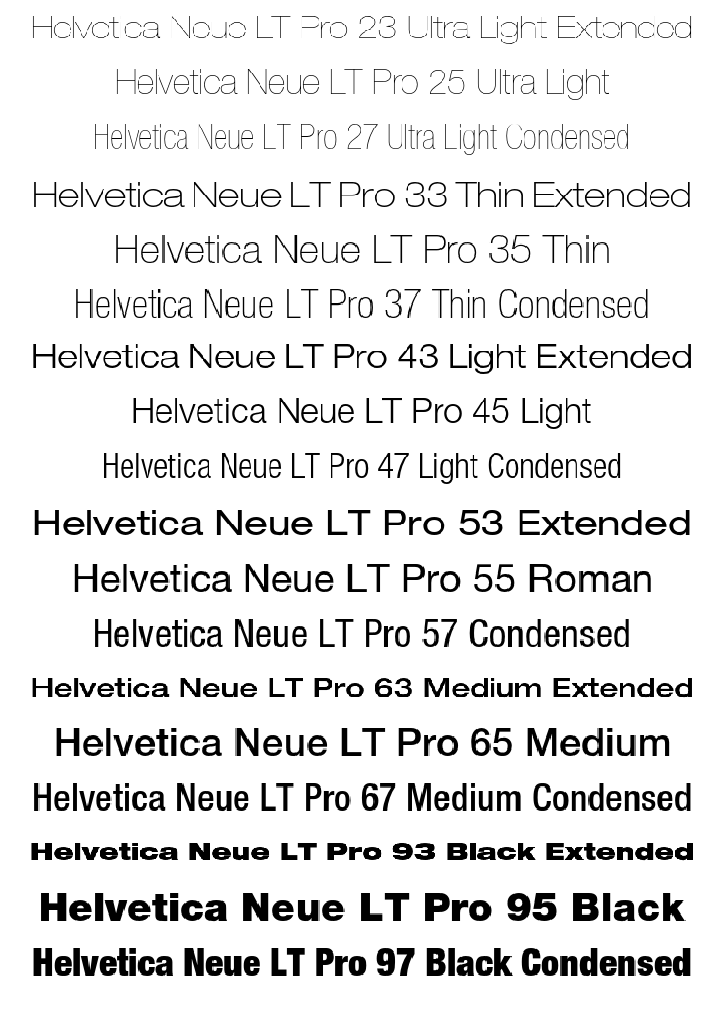

In [134]:
# Prepare data and preview fonts

fontdata = get_font_names(fontdir)
setup = make_experiment_setup(fontdata, ptsizes, outdir)
fontdata.to_csv(os.path.join(outdir, "fontdata.csv"))
setup.to_csv(os.path.join(outdir, "setup.csv"))

preview_fonts(fontdata)

In [57]:
# Batch process all files, write results

with open(textfile, 'r') as file:
    orig_text = file.read()
orig_text = breaklines(orig_text, 60)

batch_render_text(orig_text, setup, fontdata)
batch_ocr_images(setup, "ces")
results = batch_evaluate(setup, fontdata, orig_text)

results["Weight"] = pd.to_numeric(results["Font"].str[22])
results["Width"] = pd.to_numeric(results["Font"].str[23])
results.to_csv(os.path.join(outdir, "results.csv"))

In [78]:
results = pd.read_csv(os.path.join(outdir, "results.csv"))
results = results.set_index(["Weight", "Width", "Point size"])[["WER","CER"]]

/home/m17/hruska/.local/lib/python3.4/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


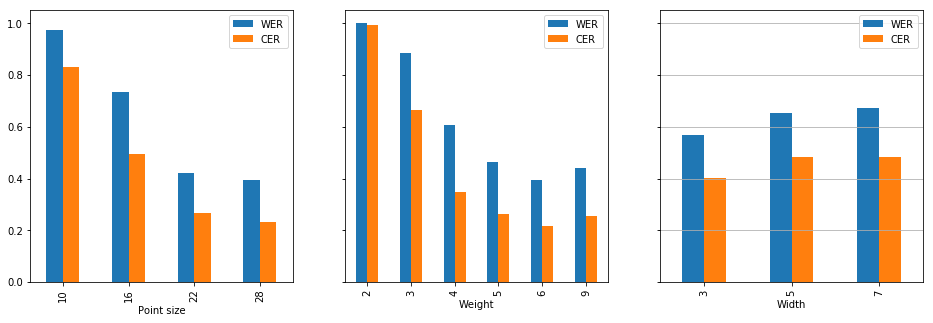

In [125]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5), sharey=True)

results.groupby("Point size").mean().plot.bar(y=["WER","CER"], ax=axes[0])
plt.grid(True, axis="y")
results.groupby("Weight").mean().plot.bar(y=["WER","CER"], ax=axes[1])
plt.grid(True, axis="y")
results.groupby("Width").mean().plot.bar(y=["WER","CER"], ax=axes[2])
plt.grid(True, axis="y")
plt.show()

These figures show average error rates by point size, weight and width respectively. Judging by both WER and CER, Tesseract is sensitive to point size and weight, but much less to font width. Not surprisingly it performs better at bigger sizes. Similarly it works better with fonts of thicker weights.

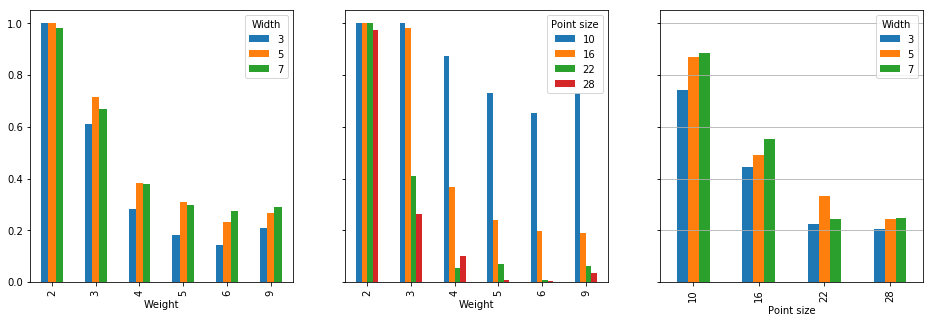

In [135]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5), sharey=True)

results.groupby(["Width", "Weight"]).mean()["CER"].unstack(0).plot.bar(ax=axes[0]);
plt.grid(True, axis="y")
results.groupby(["Point size", "Weight"]).mean()["CER"].unstack(0).plot.bar(ax=axes[1]);
plt.grid(True, axis="y")
results.groupby(["Width", "Point size"]).mean()["CER"].unstack(0).plot.bar(ax=axes[2]);
plt.grid(True, axis="y")

...............

# Experiment 2
## OCRing different typefaces

...

In [136]:
outdir = "assorted" # directory for storing generated files
fontdir = "fonts/assorted" # directory with font files
ptsizes = [16,32] # list of font sizes to generate
textfile = "cz-news.txt" # file with sample text
language = "ces" # Tesseract language model

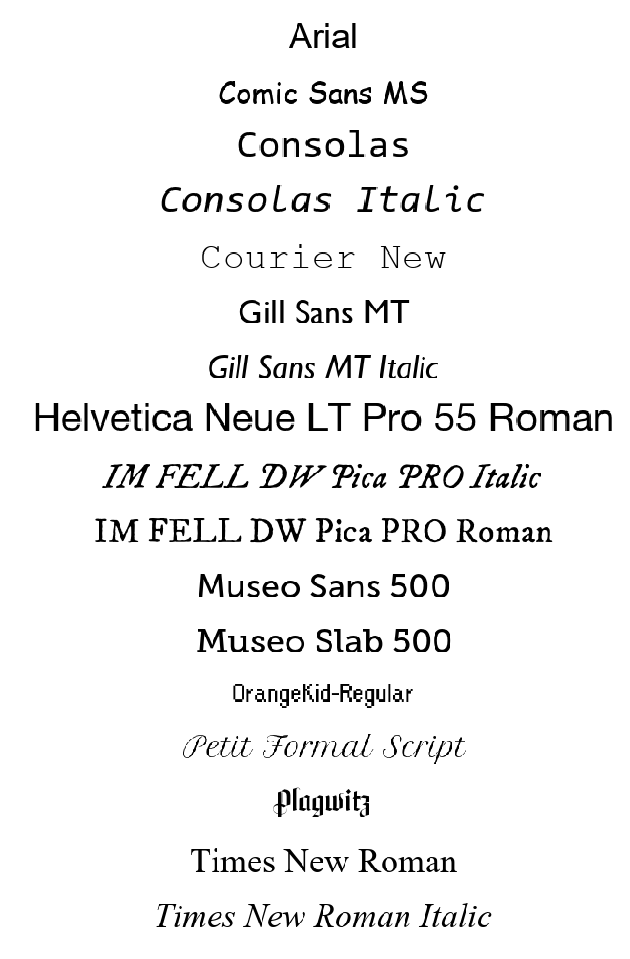

In [137]:
# Prepare data and preview fonts

fontdata = get_font_names(fontdir)
setup = make_experiment_setup(fontdata, ptsizes, outdir)
fontdata.to_csv(os.path.join(outdir, "fontdata.csv"))
setup.to_csv(os.path.join(outdir, "setup.csv"))

preview_fonts(fontdata)

In [139]:
# Batch process all files, write results

with open(textfile, 'r') as file:
    orig_text = file.read()
orig_text = breaklines(orig_text, 60)

batch_render_text(orig_text, setup, fontdata)
batch_ocr_images(setup, "ces")
results = batch_evaluate(setup, fontdata, orig_text)

results.to_csv(os.path.join(outdir, "results.csv"))

Wrote assorted/img/00.16.png
Wrote assorted/img/00.32.png
Wrote assorted/img/01.16.png
Wrote assorted/img/01.32.png
Wrote assorted/img/02.16.png
Wrote assorted/img/02.32.png
Wrote assorted/img/03.16.png
Wrote assorted/img/03.32.png
Wrote assorted/img/04.16.png
Wrote assorted/img/04.32.png
Wrote assorted/img/05.16.png
Wrote assorted/img/05.32.png
Wrote assorted/img/06.16.png
Wrote assorted/img/06.32.png
Wrote assorted/img/07.16.png
Wrote assorted/img/07.32.png
Wrote assorted/img/08.16.png
Wrote assorted/img/08.32.png
Wrote assorted/img/09.16.png
Wrote assorted/img/09.32.png
Wrote assorted/img/10.16.png
Wrote assorted/img/10.32.png
Wrote assorted/img/11.16.png
Wrote assorted/img/11.32.png
Wrote assorted/img/12.16.png
Wrote assorted/img/12.32.png
Wrote assorted/img/13.16.png
Wrote assorted/img/13.32.png
Wrote assorted/img/14.16.png
Wrote assorted/img/14.32.png
Wrote assorted/img/15.16.png
Wrote assorted/img/15.32.png
Wrote assorted/img/16.16.png
Wrote assorted/img/16.32.png
Wrote assorted

In [148]:
results = pd.read_csv(os.path.join(outdir, "results.csv"))
results = results.set_index(["Font","Point size"])[["WER","CER"]]

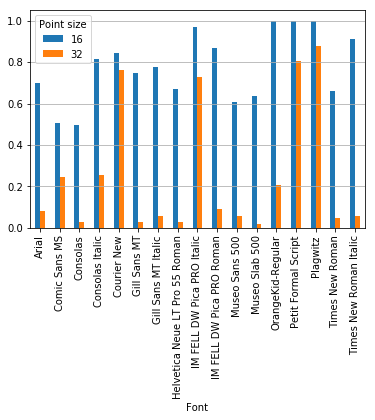

In [160]:
results.groupby(["Point size","Font"]).mean()["WER"].unstack(0).plot.bar();
plt.grid(True, axis="y")